This notebook tries to implement a diffusion model to learn a multi-dimensional, multi-modal correlated distribution. 

However, due to the choice of implenting the diffusion as only forward and the choice of loss, the optimization was not possible (no convergence). 

Could maybe be repeared. 

# Imports

In [ ]:
!pip install jax
!pip install jaxlib

!pip install --upgrade pip # To support manylinux2010 wheels.
!pip install --upgrade jax jaxlib # CPU-only
!pip install flax
!pip install --upgrade git+https://github.com/google/flax.git

!pip install distrax
!pip install --upgrade distrax

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp
import jax.random as rnd
key = rnd.PRNGKey(12)

from jax import jit, vmap
import flax.linen as nn
from jax.config import config; config.update("jax_enable_x64", True)
from jax.core import NamedShape


from functools import partial

try:
    from tqdm.auto import tqdm  # progressbar
except ImportError:
    tqdm = lambda x: x

from typing import Any, Callable, Sequence


#from jax import lax
#from flax.core import freeze, unfreeze


import distrax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import optax



/usr/local/lib/python3.7/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Diffusion Model
First try

In [ ]:
def gauss(x,mu=0,sigma=1):
  return jnp.exp(-(x-mu)**2/2/sigma**2)/jnp.sqrt(2*jnp.pi)/sigma

def p(x, mu1=-2,mu2=2,sigma1=1,sigma2=1):
  '''
  Simple addition of two gaussians N(mu1, sigma1), N(mu2, sigma2)
  Is well normalized (checked)
  '''

  return 0.5*gauss(x,mu1,sigma1) + 0.5*gauss(x,mu2,sigma2)
  
def sample_p(T,Ns,mu1 = -2, mu2 = 2, sigma1=1, sigma2=1):
  global key
  eta = rnd.uniform(key, shape=(T,Ns))
  key, _ = rnd.split(key)
  z = rnd.normal(key, shape=(T,Ns))
  key, _ = rnd.split(key)

  mask = jnp.array((eta<0.5), dtype=int)

  return mask * (z*sigma1 + mu1) + (1-mask)*(z*sigma2 + mu2)

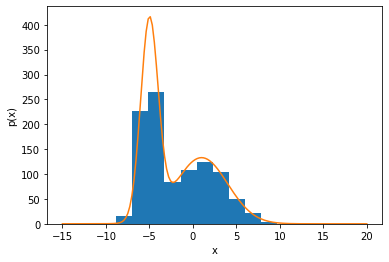

In [ ]:
m1 = 1
m2 = -5
s1 = 3
s2 = 1
x = jnp.linspace(-15,20, 150)
probs = p(x,m1,m2,s1,s2)

plt.figure()

samples = sample_p(1,1000,m1,m2,s1,s2)
plt.hist(samples)

plt.plot(x, 2000*probs)
#plt.plot(x, np.exp(-(x-1)**2/2)/np.sqrt)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()



Use : 
\begin{equation}
    -\log q_\theta(x_T) \geq \mathbb{E}_{x_0 \sim p} \left [ -\log \frac{q_\theta(x_{0:T}) }{p(x_0)} \right]
\end{equation}

using $q_\theta(x_{0:T}) = q_\theta(x_0) \prod_{t=1}^T q_\theta(x_t | x_{t-1})$, with $q_\theta(x_0) \sim \mathcal{N}(0,1), q_\theta(x_t|x_{t-1}) = \mathcal{N}(\mu_\theta(x_{t-1}), \sigma_\theta^2(x_{t-1}))$.


i.e. minimize $\mathcal{L} =\mathbb{E}_{x_0 \sim p} \left [ -\log \frac{q_\theta(x_{0:T}) }{p(x_0)} \right]$. 

In [ ]:
x = jnp.arange(1,10)
x = jnp.reshape(x, newshape=(9,1))
print(x)
print(x<9)
print(jnp.prod(x,axis=0,where=(x<6) ) )

print(np.delete(x,1))

In [ ]:
class Model:
  def __init__(self, T, p_to_approach, p_to_sample):
    global key
    self.T = int(T)
    self.p = p_to_approach
    self.sample_p = p_to_sample
    self.params = rnd.normal(key, shape=(T,) )
    key, _ = rnd.split(key)
    self.sigma=1


  def q_xT(self, params, x):
    '''
    First, the parameters are a,b s.t. mu(x0) = a and mu(x1) = b, sigma=1 for all t
    x = (x0, x1,...,x_T)
    '''
    q = gauss(x[0])
    for t in range(self.T):
      q *= gauss(x[t+1], params[t]*x[t], sigma=self.sigma)
    return q #shape 1


  def sample_q(self, Ns=1, x0=None):
    x = np.zeros((self.T+1, Ns))
    global key
    if x0 is None : 
      x[0] = rnd.normal(key, shape=(Ns,) )
      key, _ = rnd.split(key)
    else : 
      x[0] = x0  

    z = rnd.normal(key, shape=(self.T,Ns) )
    key, _ = rnd.split(key)

    for t in range(1,self.T+1):
      x[t] = self.params[t-1]*x[t-1] + self.sigma*z[t]

    return x


  def l(self, x):
    p = self.p(x[0])
    qT = vmap(self.q_xT, in_axes=(None,1), out_axes=0)(self.params, x)
    #print(x[0,qT==0])
    l = -jnp.log(qT/p)
    #print(f'qT = {qT}')
    #print(f' = {jnp.log(qT/p_Tm1)}')

    return l #shape(Ns,)

  def L(self,x):
    return jnp.mean(self.l(x), axis=0)


  def local_grad(self,x):
    grad = jax.grad(self.q_xT, argnums=0)
    q = self.q_xT(self.params,x)
    #print(f'q = {q}')

    return -grad(self.params, x)/q


  def sgd(self,Ns,learning_rate,epochs,looped=0):
    assert looped <= 20
    tol = 1e-6
    grad_prec = 0

    output = {}
    output['loss'] = []
    output['grad'] = []
    output['parameters'] = []
    output['parameters'].append(self.params)


    for i in tqdm(range(epochs)):

      x0 = self.sample_p(1,Ns)
      #print(f'x0 = {x0}')
      x = self.sample_q(Ns,x0)
      #print(f'x = {x}')
      output['loss'].append(self.L(x))
      #print(self.L(x))


      grad = jnp.mean(vmap(self.local_grad, in_axes=1)(x), axis=0)
      #print(grad)
      output['grad'].append(grad)
      if np.linalg.norm(grad_prec-grad) < tol:
        return output


      self.params -= learning_rate*grad
      output['parameters'].append(self.params)
      grad_prec = grad

      if np.isnan(grad).any() or np.abs(grad).any() == np.inf:
        return self.sgd(Ns,learning_rate,epochs,looped=looped+1)


    return output




In [ ]:
T = 2
mu1=-1
mu2=-2 
sigma1=1
sigma2=3
example = Model(T=T, p_to_approach=lambda x : p(x,mu1,mu2,sigma1,sigma2), p_to_sample=lambda T,Ns : sample_p(T,Ns,mu1,mu2,sigma1,sigma2))

samples = example.sample_p(50)
#print(samples.shape)
#print(samples[0])

##print(example.q_xT(example.params,samples).shape )
#print(example.l(samples).shape)
#print(example.L(samples).shape)

#print(example.local_grad(samples[:,0]))

out = example.sgd(10,0.01,50)
#print(example.sample_q(1))

In [ ]:
# Parameters
T = 1
mu1=1
mu2=-5 
sigma1=1
sigma2=1


test = Model(T=T, 
             p_to_approach = lambda Ns : p(Ns,mu1,mu2,sigma1,sigma2), 
             p_to_sample = lambda T,Ns : sample_p(T,Ns,mu1,mu2,sigma1,sigma2)
             )




out = test.sgd(Ns=5000, learning_rate=0.5, epochs=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

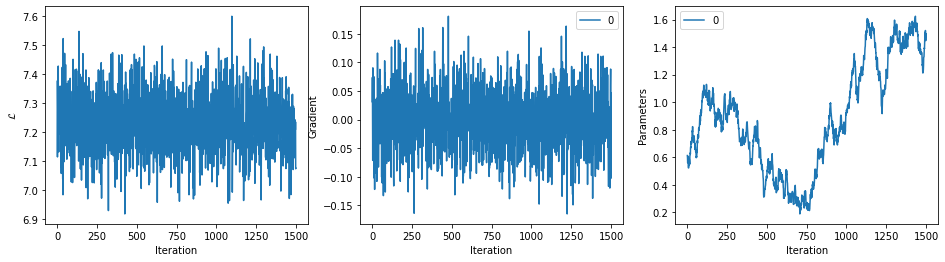

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(out['loss'])
plt.xlabel('Iteration')
plt.ylabel(r'$\mathcal{L}$')


plt.subplot(1,3,2)
plt.plot(out['grad'])
#plt.plot(out['grad'][:,1])
plt.xlabel('Iteration')
plt.ylabel('Gradient')
plt.legend(range(T))

plt.subplot(1,3,3)
plt.plot(out['parameters'])
plt.xlabel('Iteration')
plt.ylabel('Parameters')
plt.legend(range(T))


plt.show()


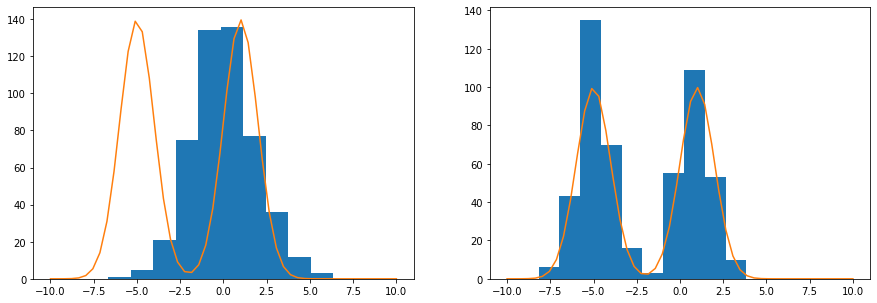

In [ ]:
samples_q = test.sample_q(500)
samples_p = test.sample_p(1,500)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(samples_q[-1], label='q')
plt.plot(np.linspace(-10,10), 700*test.p(np.linspace(-10,10)))


plt.subplot(1,2,2)
plt.hist(samples_p, label='p')
plt.plot(np.linspace(-10,10), 500*test.p(np.linspace(-10,10)))
plt.show()

# Diffusion Model
try 2


## Distribution to learn

In [ ]:
def normal(x,mu=0,sigma=1):
  return jnp.exp(-(x-mu)**2/2/sigma**2)/jnp.sqrt(2*jnp.pi)/sigma


class Distribution:
  '''
  Creates a distribution which is an addition of two gaussians.
  The proportionality between the two is given by prop. 

  x ~ prop*N(mu1,sigma1) + (1-prop)*N(mu2,sigma2). 
  '''

  def __init__(self,mu1,mu2,sigma1,sigma2,prop=0.5):
    assert prop <= 1 and prop >= 0
    self.mu1 = mu1
    self.mu2 = mu2
    self.sigma1 = sigma1
    self.sigma2 = sigma2

    self.prop=prop

  def p(self,x):
    '''
    probability of a sample x
    '''
    return self.prop*normal(x,self.mu1,self.sigma1) + (1-self.prop)*normal(x,self.mu2,self.sigma2)

  @partial(jit, static_argnums=0)
  def log_p(self,x):
    '''
    unnormalized log probability of a sample
    does not need to be a nomralized probability
    '''
    return jnp.log( self.prop*jnp.exp(-(x-self.mu1)**2/2/self.sigma1**2)/self.sigma1 + (1-self.prop)*jnp.exp(-(x-self.mu2)**2/2/self.sigma2**2)/self.sigma2 )
  
  def sample(self,T=1,Ns=500):
    '''
    Draw samples according to p (normally we don't have it, here we are only testing)
    only works if p is normalized
    '''
    global key
    eta = rnd.uniform(key, shape=(T,Ns))
    key, _ = rnd.split(key)
    mask = jnp.array((eta<self.prop), dtype=int)

    z = rnd.normal(key, shape=(T,Ns))
    key, _ = rnd.split(key)    

    return mask * (z*self.sigma1 + self.mu1) + (1-mask)*(z*self.sigma2 + self.mu2)


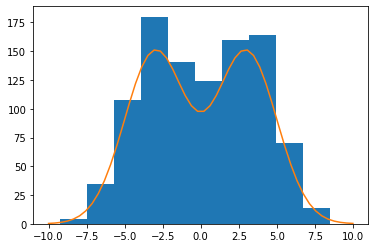

In [ ]:
# Test
T = 2
mu1=-3
mu2=3
sigma1=2
sigma2=2


p = Distribution(mu1,mu2,sigma1,sigma2,prop=0.5)

plt.figure()
plt.hist(p.sample(Ns=1000))
x = np.linspace(-10,10)
plt.plot(x, 1500*p.p(x))
plt.show()

## NN for the mus

In [ ]:
class SimpleDense(nn.Module):
  features: int
  kernel_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    kernel = self.param('kernel',
                        self.kernel_init, # Initialization function
                        (inputs.shape[-1], self.features))  # shape info.
    y = jnp.dot(inputs, kernel)
    bias = self.param('bias', self.bias_init, (self.features,))
    y = y + bias
    return y

class SimpleMLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = SimpleDense(feat)(x)
      if i != len(self.features) - 1:
        x = jnp.tanh(x)
    return x

class BiasOnly(nn.Module):
  bias_init : Callable = nn.initializers.constant(3)

  @nn.compact
  def __call__(self,inputs):
    bias = self.param('bias', self.bias_init, (inputs.shape[-1],))
    return bias

In [ ]:
# Test bias
model = BiasOnly()
x = rnd.uniform(key, (5,))

params = model.init(key, x)
params
model.apply(params, x)

DeviceArray([3., 3., 3., 3., 3.], dtype=float32)

In [ ]:
# Test the implementation
key1, key2 = rnd.split(rnd.PRNGKey(0), 2)
x = rnd.uniform(key1, (1,))

model = SimpleMLP(features=[5,3,1]) #3 dense layers nn
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameters:\n', params)
print('output:\n', y)

In [ ]:
class DiffusionModel:
  '''
  Diffusion model
  Passes a normally drawn sample x0 through T parametrized (with the previous state) gaussians
  '''
  def __init__(self, T, distribution_to_approach, features):
    assert len(features) == T
    self.T = int(T)
    self.to_approach = distribution_to_approach

    # Generate NN for the mus
    key = rnd.PRNGKey(2)
    x = rnd.uniform(key, (1,1))
    self.models = {} ## models of each mu, sigma
    self.params = {} ## parameters of each mu, sigma
    for t,f in enumerate(features):
      model_mu = SimpleMLP(features=f) 
      self.models[f'μ_{t}'] = model_mu
      self.params[f'μ_{t}'] = model_mu.init(key, x) 
      key, _ = rnd.split(key, 2)
    '''
      model_sigma = BiasOnly()
      self.models[f'σ_{t}'] = model_sigma
      self.params[f'σ_{t}'] = model_sigma.init(key, x) 
      key, _ = rnd.split(key, 2)
    '''
    self.sigma = jnp.ones( self.T )
      
  def sample_q(self,key,Ns):
    '''
    Sample Ns samples from the distribution q_theta(x0,...,xT)
    Ns : number of samples wished
    returns : Ns chains (x0...xT), i.e. an array of shape (T+1,Ns)
    '''
    x = np.zeros((self.T+1, Ns,1))

    x[0] = rnd.normal(key, shape=(Ns,1) )
    key, _ = rnd.split(key)
    z = rnd.normal(key, shape=(self.T,Ns,1) )
    key, _ = rnd.split(key)

    # x_t+1 = mu(xt) + sigma(xt)* N(0,1)
    for t in range(0,self.T):
      x[t+1] = self.models[f'μ_{t}'].apply(self.params[f'μ_{t}'],x[t]) + self.sigma[t]*z[t+1]

    return x[...,0] #shape(T+1,Ns)

  @partial(jit, static_argnums=(0,))
  def single_log_q(self,params,x):
    '''
    Computes the log probability of a generated chain (x0,...,xT) for only one sample
    following q(x0,...,xT) = normal(x0) * prod normal(mu = mu(xt), sigma=sigma(xt))
    Input : x ONE single sample (T+1,)
    returns : log_q ()
    '''
    assert x.ndim == 1
    x = x.reshape(self.T+1,1)
    q = normal(x[0])
    for t in range(self.T):
      q *= normal(x[t+1], self.models[f'μ_{t}'].apply(params[f'μ_{t}'],x[t]), sigma=self.sigma[t] )
    log_q = jnp.log(q[0])

    return log_q

  @partial(jit, static_argnums=(0,))
  def log_q(self,params,data):
    '''
    Computes the log probabilities of multiple generated chain (x0,...,xT)
    following q(x0,...,xT) = normal(x0) * prod normal(mu = mu(xt), sgima=1)
    Input : x (T+1,Ns)
    returns : log_q for each sample (Ns,) 
    '''
    return vmap(self.single_log_q, in_axes=(None,1), out_axes=0)(params,data)

  @partial(jit, static_argnums=(0,))
  def pseudo_loss(self,params,data): 
    '''
    Defines the false loss which one derives to minimize the real loss
    (only used as a tool for the gradient, does not mean anything)
    data : samples chains (T+1,Ns)
    returns : pseudo loss ()
    '''
    local = -self.log_q(params,data) * self.to_approach.log_p(data[-1])

    return jnp.mean(local, axis=-1)

  @partial(jit, static_argnums=(0,))
  def loss_and_grad(self,params,data):
    '''
    Computes the loss and gradient for a bunch of samples
    L = E[-logp(xT)], gradL = E[-logp(xT) * grad logq(x0,...,xT)]
    data : samples chains (T+1,Ns)
    returns L () and gradL (dictionnary of parameters)
    '''
    logp = self.to_approach.log_p(data[-1])
    L = -np.mean(logp, axis=-1)
    
    grad_l = jax.grad(self.pseudo_loss, 0)(params, data)
    
    return L, grad_l

  '''
  # Testing KL divergence -> did not work (integration is false)
  @partial(jit, static_argnums=(0,))
  def test_pseudo_loss(self,params,x): 
    log_q = self.single_log_q(params,x)
    return log_q*( 0.5*log_q - self.to_approach.log_p(x[-1]) )

  @partial(jit, static_argnums=(0,))
  def test_local_grad(self,params,x):
    g = jax.grad(self.test_pseudo_loss,0)(params,x)
    return  g

  def test_loss_and_grad(self,x):
    Ns = x.shape[-1]
    logp = self.to_approach.log_p(x[-1])
    logq = jax.vmap(self.test_pseudo_loss,(None,1), -1)(self.params,x)

    L = np.mean(logq - logp)
    #print(L)
    grad_l = self.test_local_grad(self.params,x[:,0])
    for i in range(1,Ns):
      new_g = self.test_local_grad(self.params,x[:,i])
      grad_l = jax.tree_map(lambda x,y : x+y, grad_l, new_g )
    
    return L, jax.tree_map(lambda x : x/Ns, grad_l)
    '''


  0%|          | 0/3000 [00:00<?, ?it/s]

0 Loss =  1.7628580704761685
200 Loss =  1.7731317691227058
400 Loss =  1.732025812098796


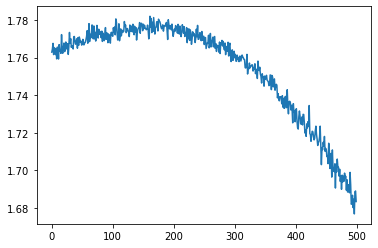

600 Loss =  1.61663302305238
800 Loss =  1.4942321516659343
1000 Loss =  1.4350754316405707


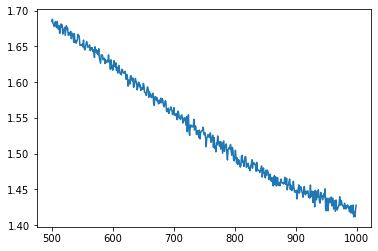

1200 Loss =  1.4339779620989543
1400 Loss =  1.563955207767384


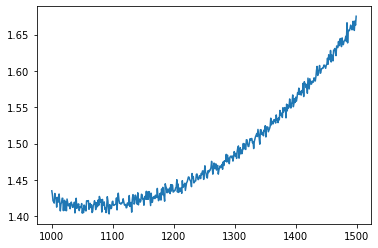

KeyboardInterrupt: ignored

In [ ]:
# Distribution to learn
mu1=-3
mu2=3
sigma1=2
sigma2=2
prop = 0.3
p_to_approach = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

# Define model
T = 5
features = [[5,5,1], [5,5,1], [5,5,1], [5,5,1], [5,5,1]] #[[5,7,3,1], [5,7,3,1], [5,7,3,1], [3,5,7,3,1], [5,7,3,1]] #[[2,5,3,7,1], [2,10,3,1]] #[[5,7,3,1], [5,7,3,1], [5,7,3,1], [3,5,7,3,1], [5,7,3,1]]
model = DiffusionModel(T,p_to_approach,features)

# Optimization parameters
lr = 1e-3

nsteps = int(3000)
Ns = 5000


# Define Optimizer
tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(model.params)



# Learn
L = np.zeros(nsteps)

key = rnd.PRNGKey(12)

for i in tqdm(range(nsteps)):
  data = model.sample_q(key, Ns=Ns)
  key, _ = rnd.split(key, 2)
  L[i], grads = model.loss_and_grad(model.params,data)

  if jnp.abs(L[i]) == np.infty or jnp.isnan(L[i]):
    print(grads)
    break

  updates, opt_state = tx.update(grads, opt_state)
  model.params = optax.apply_updates(model.params, updates)
  
  if i % 200 == 0:
    print(i, 'Loss = ', L[i])
    
  if i>0 and i%500==0 :
    plt.figure()
    plt.plot(range(i-500, i), L[i-500:i])
    plt.show()


In [ ]:
# TESTING GRADIENT
mu1=-3
mu2=3
sigma1=2
sigma2=2
prop = 0.3
p_to_approach = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

# Define model
T = 1
features = [[3,5,1]]
model = DiffusionModel(T,p_to_approach,features)



Ns = int(1e6)
idx = 0
step = 1e-3



data = model.sample_q(key, Ns=Ns)
_, real_g = model.loss_and_grad(model.params, data)


model.params['μ_0']['params']['SimpleDense_0']['kernel'].at[0,1].add(step)
data = model.sample_q(key, Ns=Ns)
plus_l, _ = model.loss_and_grad(model.params, data)


model.params['μ_0']['params']['SimpleDense_0']['kernel'].at[0,1].add(-2*step)
data = model.sample_q(key, Ns=Ns)
minus_l, _ = model.loss_and_grad(model.params, data)


model.params['μ_0']['params']['SimpleDense_0']['kernel'].at[0,1].add(step)
data = model.sample_q(key, Ns=Ns)
finite_diff = (plus_l - minus_l)/step/2

print(real_g['μ_0']['params']['SimpleDense_0']['kernel'][0,1], finite_diff)

# gradient does not seem to be right...

0.003494516819297614 0.0


In [ ]:
model.params['μ_0']['params']['SimpleDense_0']['kernel'][0,0]


DeviceArray(-1.5348857, dtype=float64)

In [ ]:
# Distribution to learn
mu1=-1
mu2=1 
sigma1=3
sigma2=3
prop = 0.5
p_to_approach = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

# Define model
T = 3
features = [[3,5,3], [3,5,3], [3,5,3]] #[[5,7,3,1], [5,7,3,1], [5,7,3,1], [3,5,7,3,1], [5,7,3,1]] #[[2,5,3,7,1], [2,10,3,1]] #[[5,7,3,1], [5,7,3,1], [5,7,3,1], [3,5,7,3,1], [5,7,3,1]]
model = DiffusionModel(T,p_to_approach,features)

# Optimization parameters
lr = 1e-3

nsteps = int(200)
Ns = 5000


# Define Optimizer
tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(model.params)




# Learn
sigmas = np.linspace(2.5,1,4)
L = np.zeros(4*nsteps + 300)
L_end = np.zeros(nsteps)

for k,sigma in enumerate(sigmas):
  model.to_approach = Distribution(mu1,mu2,sigma1*sigma,sigma2*sigma,prop=prop)
  
  for i in tqdm(range(nsteps)):
    x = model.sample_q(Ns=Ns)
    L[i + k*nsteps], grads = model.loss_and_grad(x)
    if jnp.abs(L[i + k*nsteps]) == np.infty or jnp.isnan(L[i + k*nsteps]):
      print(grads)
      break

    updates, opt_state = tx.update(grads, opt_state)
    model.params = optax.apply_updates(model.params, updates)
    if i % 10 == 0:
      print(f'{sigma}, Loss step {i}: ', L[i + k*nsteps])

  plt.plot(np.linspace(-10,10), 
           500*np.exp(model.to_approach.log_p(np.linspace(-10,10) )) )
  plt.hist(model.sample_q(500)[-1])
  plt.show()

for i in range(300):
  x = model.sample_q(Ns=Ns)
  L[4*nsteps + i], grads = model.loss_and_grad(x)
  if jnp.abs(L[i + 4*nsteps]) == np.infty or jnp.isnan(L[i + 4*nsteps]):
    print(grads)
    break

  updates, opt_state = tx.update(grads, opt_state)
  model.params = optax.apply_updates(model.params, updates)
  if i % 10 == 0:
    print(f'{sigma}, Loss step {i}: ', L[i + 4*nsteps])

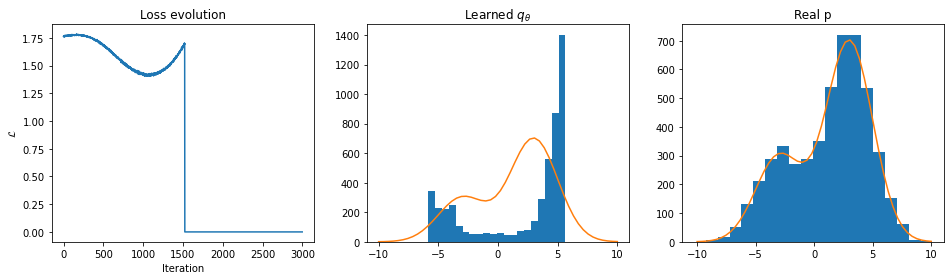

2.0608785747932443 16.544702476320396


In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)

plt.title('Loss evolution')
plt.plot(L)
plt.xlabel('Iteration')
plt.ylabel(r'$\mathcal{L}$')


samples_q = model.sample_q(key, Ns=5000)[-1]
samples_p = model.to_approach.sample(T=1,Ns=5000)

x = np.linspace(-10,10)
real_probs = np.exp(model.to_approach.log_p(x) )

plt.subplot(1,3,2)
plt.title(r'Learned $q_\theta$')
plt.hist(samples_q, label='q', bins=20)
plt.plot(x, 2000*real_probs)


plt.subplot(1,3,3)
plt.title('Real p')
plt.hist(samples_p, label='p', bins=20)
plt.plot(x, 2000*real_probs )

#plt.savefig(f'test_diffusion.png', dpi=200, bbox_inches='tight')
plt.show()

print(np.mean(samples_q), np.var(samples_q))